In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9543968266527818685
xla_global_id: -1
]


In [230]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Conv2D,  MaxPooling2D, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

my_seed = 1027

tf.random.set_seed(my_seed)
np.random.seed(my_seed)

import os
import csv
from tqdm import tqdm

import librosa
import librosa.display
    
import multiprocessing as mp
from joblib import Parallel, delayed

# 오디오 원시 파형 shape

In [8]:
# 데이터를 저장할 리스트 초기화
data_list = []

# CSV 파일 경로 설정
dataset_folder_list = ['dataset','dataset2']  # CSV 파일들이 저장된 폴더 경로
file_extension = '.csv'

input_label_list = []

# 각 파일에서 데이터 추출
for dataset_folder in dataset_folder_list:
    for filename in os.listdir(dataset_folder):
        if filename.endswith(file_extension):
            file_path = os.path.join(dataset_folder, filename)
            
            with open(file_path, 'r') as csv_file:
                csv_reader = csv.reader(csv_file)
                next(csv_reader)  # 첫 번째 행(열 이름)을 건너뜁니다.
                data = list(csv_reader)
                data = np.array(data, dtype=np.float32)  # CSV 데이터를 NumPy 배열로 변환
                for i in range(0, 201, 1):  # 2~251행을 사용하도록 수정
                    input_data = data[i:i+49]
                    data_list.append(input_data)

                    label_list = []
                    for label in filename.split('.')[0].split('_'):
                        label_list.append(float(label))
                    if dataset_folder == 'dataset':
                        label_list.append(1)
                    elif dataset_folder == 'dataset2':
                        label_list.append(0)
                    label_array = np.array(label_list)
                    input_label_list.append(label_array)
                                 
input_label_array = np.array(input_label_list)

# 데이터 리스트를 NumPy 배열로 변환
input_data_array = np.array(data_list)

input_data_list = []

for data in input_data_array:
    num_rows = 7
    num_columns = 7
    num_channels = 4

    reshaped_data_list = []

    for i in range(num_channels):
        channel_data_list = []
        for j in range(len(data)):
            channel_data_list.append(data[j][i])
        channel_data_array = np.array(channel_data_list).reshape(num_rows,num_columns)
        reshaped_data_list.append(channel_data_array)   
    reshaped_data_array = np.array(reshaped_data_list)
    
    input_data_list.append(reshaped_data_array)
    
input_data_array = np.array(input_data_list)
                            
input_data_array_t = input_data_array.transpose(0, 2, 3, 1)                            

In [131]:
input_label_array.T[2]

array([1., 1., 1., ..., 0., 0., 0.])

In [132]:
last_1_index = np.where(input_label_array.T[2] == 1)[0][-1]

In [136]:
input_label_array.T[2][0:89043]

array([1., 1., 1., ..., 1., 1., 1.])

In [140]:
input_data_array[0:89043].shape

(89043, 4, 7, 7)

In [9]:
print(input_data_array.shape)
print(input_label_array.shape)

print(input_data_array_t.shape)

(151755, 4, 7, 7)
(151755, 3)
(151755, 7, 7, 4)


# 오디오 특성 전처리

In [631]:
audio_file = 'test.wav'
real_test_data, sr = librosa.load(audio_file)

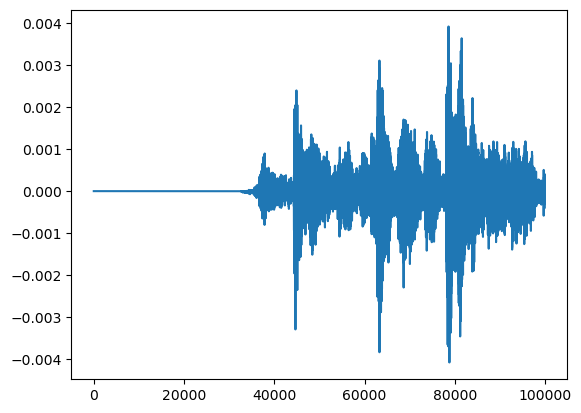

In [646]:
plt.plot(real_test_data[100:100000])

In [604]:
audio_csv = pd.read_csv('test.csv')
audio_array = np.array(audio_csv.iloc[:,3]).astype(np.float64)

In [605]:
audio_array

array([ 70.,  84.,  88.,  87.,  80.,  95.,  84.,  71., 107.,  86.,  96.,
        85.,  88.,  75.,  79.,  78.,  75.,  84., 104.,  79., 102.,  82.,
        78.,  82.,  86.,  50.,  90., 104.,  73.,  69.,  77.,  82., 109.,
        80.,  58.,  54.,  85.,  98.,  80.,  84.,  59.,  55.,  64., 112.,
        72., 100., 121.,  99., 107., 112., 115., 102., 105., 106., 138.,
       124., 105.,  91., 100., 105.,  92., 100., 100.,  93.,  85., 125.,
       171., 116.,  79., 117., 136., 122., 164., 132., 142., 114., 131.,
       111., 177.,  87.,  96., 122., 103., 110.,  81., 125., 100.,  97.,
        76.,  95.,  94., 150., 128., 138.,  89., 101.,  98., 107., 112.,
        97.,  85.,  99.,  86.,  81.,  87.,  82.,  81.,  73.,  76.,  99.,
        79.,  80.,  96., 106., 111.,  63.,  94.,  98.,  85., 148.,  93.,
       109.,  85., 124.,  66., 115.,  89.,  79., 130.,  83.,  64.,  66.,
        46.,  70.,  61.,  34.,  99.,  55.,  66.,  59.,  65.,  66.,  75.,
       108.,  57.,  54.,  72.,  72.,  48.,  53.,  8

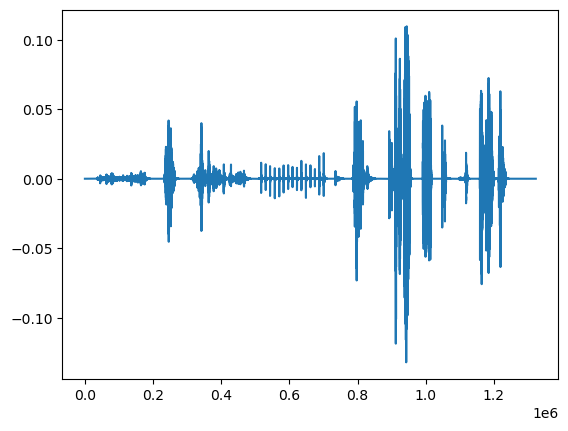

In [265]:
plt.plot(y)

C:\Users\chanj\.conda\envs\zolnon\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=49

이 경고 메시지는 librosa 라이브러리를 사용하여 스펙트로그램을 계산하려고 할 때 발생하는 것으로 보입니다. 이 메시지의 의미는 입력 신호의 길이가 n_fft 파라미터로 설정된 FFT (고속 퓨리에 변환) 크기보다 작다는 것입니다.

FFT는 주어진 길이의 입력 신호를 주파수 도메인으로 변환하는 데 사용되며, 입력 신호의 길이는 n_fft에 지정된 값보다 크거나 같아야 합니다. 만약 입력 신호의 길이가 n_fft 값보다 작다면 librosa는 경고 메시지를 발생시킵니다.


C:\Users\chanj\.conda\envs\zolnon\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
  
 n_fft : int > 0 [scalar]
        length of the FFT window
        
 n_mels : int > 0 [scalar]
        number of Mel bands to generate
        
n_fft (Short for "Number of FFT points"):
n_fft는 FFT (고속 퓨리에 변환)를 계산할 때 사용되는 창 크기 또는 프레임 크기를 나타냅니다.
FFT는 시간 도메인의 신호를 주파수 도메인으로 변환하는 변환이며, 신호를 작은 프레임 또는 창으로 나누어 이러한 프레임에 대한 FFT를 수행합니다.
n_fft 값은 주파수 해상도와 시간 해상도를 결정하는 중요한 매개 변수입니다. 큰 n_fft 값은 주파수 해상도를 높이고 작은 n_fft 값은 시간 해상도를 높입니다.
일반적으로 n_fft 값은 2의 거듭제곱 (예: 256, 512, 1024)으로 선택되며, 일반적으로 오버랩하는 프레임 간의 시간 해상도와 주파수 해상도 사이의 균형을 찾는 데 사용됩니다.

n_mels (Short for "Number of Mel filterbanks"):
n_mels는 멜 스펙트로그램에서 사용되는 멜 필터의 수를 나타냅니다.
멜 필터는 주파수를 멜 스케일로 변환하는 데 사용되며, 이것은 인간의 청각 특성에 맞게 주파수를 그룹화하는 데 도움을 줍니다.
멜 스펙트로그램은 주파수 스케일을 멜 스케일로 변환하고 그 주파수 대역대의 에너지를 표현합니다.
n_mels 값을 높이면 멜 스펙트로그램의 주파수 해상도가 높아지고, 더 많은 주파수 대역대를 감지할 수 있게 됩니다.

In [632]:
mel_spectrogram = librosa.feature.melspectrogram(y=real_test_data, sr=sr, n_fft=2048, n_mels=64)

In [633]:
mel_spectrogram.shape

(64, 2584)

In [634]:
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

In [635]:
log_mel_spectrogram.shape

(64, 2584)

In [636]:
log_mel_spectrogram.flatten()

array([-80., -80., -80., ..., -80., -80., -80.], dtype=float32)

 ...]

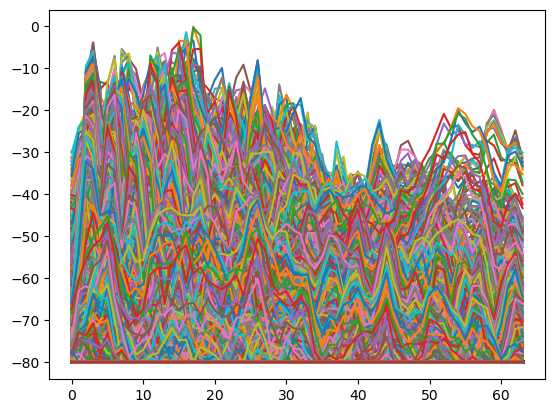

In [637]:
plt.plot(log_mel_spectrogram)

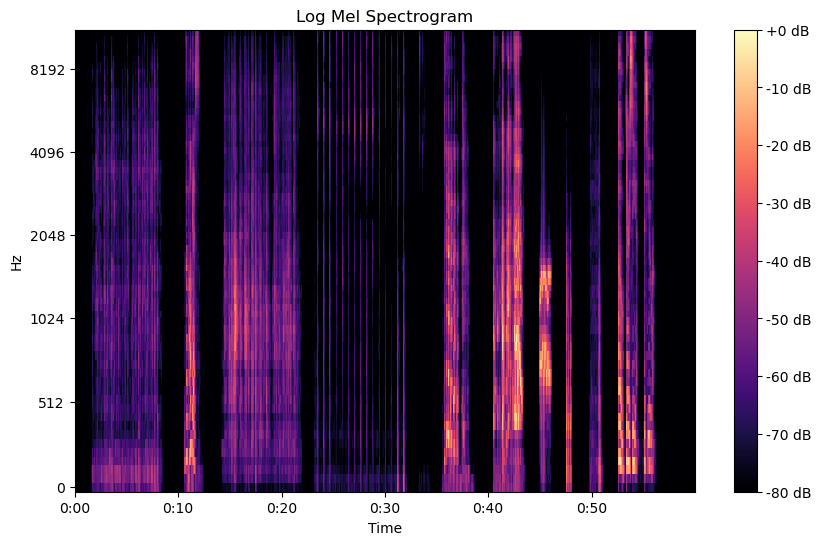

In [638]:
# MFCC 및 로그 멜 스펙트로그램을 시각화합니다.
plt.figure(figsize=(10, 6))

# 로그 멜 스펙트로그램 시각화
librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.show()

In [639]:
# MFCC를 추출합니다.
mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, sr=49)

In [641]:
mfcc

array([[-640., -640., -640., ..., -640., -640., -640.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]], dtype=float32)

 ...]

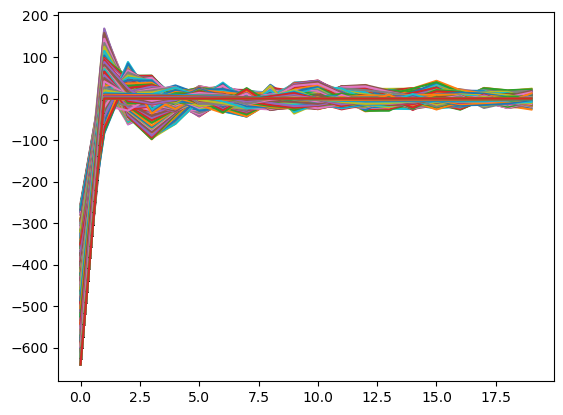

In [642]:
plt.plot(mfcc)

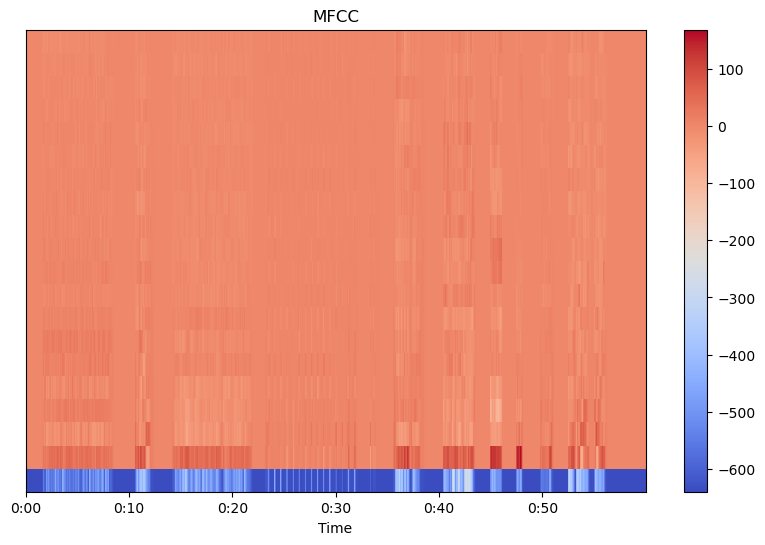

In [643]:
# MFCC 시각화
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

In [11]:
print(mp.cpu_count())

8


In [10]:
# Define a function to extract features from a single sample
def extract_features(sample):
    feature_list = []
    for j in range(4):
        sub_sample = sample[j].flatten()
        mel_spectrogram = librosa.feature.melspectrogram(y=sub_sample, sr=49, n_fft=7, n_mels=7)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, sr=49)
        
        feature = np.concatenate((log_mel_spectrogram.flatten(), mfcc.flatten()))
        feature_list.append(feature)
        
    return np.array(feature_list).reshape((1, 14, 4))

# Use parallel processing to extract features
with Parallel(n_jobs=-1) as parallel:
    input_feature_list = parallel(delayed(extract_features)(sample) for sample in tqdm(input_data_array_t))

input_feature_array = np.array(input_feature_list)


100%|████████████████████████████████████████████████████████████████████████| 151755/151755 [01:52<00:00, 1346.65it/s]


In [12]:
input_feature_array.shape

(151755, 1, 14, 4)

# 모델 관련

In [34]:
help(Conv2D)

Help on class Conv2D in module keras.layers.convolutional.conv2d:

class Conv2D(keras.layers.convolutional.base_conv.Conv)
 |  Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |  
 |  2D convolution layer (e.g. spatial convolution over images).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers or `None`, does not include the sample axis),

In [13]:
help(Input)

Help on function Input in module keras.engine.input_layer:

Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)
    `Input()` is used to instantiate a Keras tensor.
    
    A Keras tensor is a symbolic tensor-like object, which we augment with
    certain attributes that allow us to build a Keras model just by knowing the
    inputs and outputs of the model.
    
    For instance, if `a`, `b` and `c` are Keras tensors,
    it becomes possible to do:
    `model = Model(input=[a, b], output=c)`
    
    Args:
        shape: A shape tuple (integers), not including the batch size.
            For instance, `shape=(32,)` indicates that the expected input
            will be batches of 32-dimensional vectors. Elements of this tuple
            can be None; 'None' elements represent dimensions where the shape is
            not known.
        batch_size: optional static batch size (integer).
        name: An optional name

### 간단 model v1

In [ ]:
# 데이터 입력 크기 설정
input_shape = (5, 10, 4)

# 모델 생성
input_layer = Input(shape=input_shape)
x = Conv2D(1, (3,6), activation='relu')(input_layer)
x = Flatten()(x)
output_layer = Dense(2)(x)  # 2개의 연속적인 값 예측을 위한 출력 레이어

model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')  # 평균 제곱 오차를 손실 함수로 사용

# 모델 요약 정보 출력
model.summary()

### 간단 model v2

In [ ]:
# 데이터 입력 크기 설정
input_shape = (5, 10, 4)

# 모델 생성
input_layer = Input(shape=input_shape)
x = Conv2D(2, (3,6), activation='relu')(input_layer)
x = Flatten()(x)
x = Dense(12)(x)
output_layer = Dense(2)(x)  # 2개의 연속적인 값 예측을 위한 출력 레이어

model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')  # 평균 제곱 오차를 손실 함수로 사용

# 모델 요약 정보 출력
model.summary()

### 간단 model v3

val_loss: 882.4963

In [167]:
# 데이터 입력 크기 설정
input_shape = (5, 10, 4)

# 모델 생성
input_layer = Input(shape=input_shape)
x = Conv2D(32, (2, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(2)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5, 10, 4)]        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 8, 32)          800       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 2)                 258       
                                                           

### 간단 model v4

Total params: 39,458

데이터셋 수정 (34170, 4, 7, 7) (34170, 2)

batch_size = 16
epochs = 10
val_loss: 302.9620
x_rmse: 20.4, y_rmse: 13.8

In [182]:
# 데이터 입력 크기 설정
input_shape = (7, 7, 4)

# 모델 생성
input_layer = Input(shape=input_shape)
x = Conv2D(64, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(2)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 7, 7, 4)]         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 64)          2368      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 flatten_11 (Flatten)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 32)                4128      
                                                          

### 간단 model v5 

Trainable params: 412,482

batch_size = 32
epochs = 10 (10부터 과적합)
loss: 152.5903 - val_loss: 209.2759
x_rmse: 18.0, y_rmse: 9.7

batch_size = 16
epochs = 10 (10부터 과적합)
loss: 135.9231 - val_loss: 139.4928
x_rmse: 13.2, y_rmse: 10.3

batch_size = 8
epochs = 9
loss: 155.2957 - val_loss: 157.3475
x_rmse: 14.9, y_rmse: 9.6

In [237]:
# 데이터 입력 크기 설정
input_shape = (7, 7, 4)
input_layer = Input(shape=input_shape)

# 모델 생성
x = Conv2D(128, (2, 2), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (2, 2), activation='relu')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(2)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 7, 7, 4)]         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 6, 128)         2176      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 3, 3, 128)        0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 2, 2, 256)         131328    
                                                                 
 flatten_13 (Flatten)        (None, 1024)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               262400    
                                                          

### 간단 model v6

Trainable params: 677,058

batch_size = 32
epochs = 10
loss: 136.5500 - val_loss: 123.0808
x_rmse: 12.8, y_rmse: 9.1

In [246]:
# 데이터 입력 크기 설정
input_shape = (7, 7, 4)
input_layer = Input(shape=input_shape)

# 모델 생성
x = Conv2D(256, (2, 2), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(512, (2, 2), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(2)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 7, 7, 4)]         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 6, 6, 256)         4352      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3, 3, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 2, 2, 512)         524800    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 512)        0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 512)               0  

### 간단 model v7 (residual block 추가)

Total params: 939,714

batch_size = 32
epochs = 10
loss: 126.3182 - val_loss: 247.2575
epochs = 7, loss: 175.0907 - val_loss: 198.9781
x_rmse: 20.0, y_rmse: 9.8

In [535]:
# 데이터 입력 크기 설정
input_shape = (7, 7, 4)
input_layer = Input(shape=input_shape)

# 모델 생성
x = Conv2D(256, (2, 2), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(512, (2, 2), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

residual = x  # 입력을 보존
x = Dense(512, activation='relu')(x)
x = Add()([x, residual])  # 입력과 출력을 더함

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(2)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 7, 7, 4)]    0           []                               
                                                                                                  
 conv2d_66 (Conv2D)             (None, 6, 6, 256)    4352        ['input_35[0][0]']               
                                                                                                  
 max_pooling2d_25 (MaxPooling2D  (None, 3, 3, 256)   0           ['conv2d_66[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 2, 2, 512)    524800      ['max_pooling2d_25[0][0]']

### 간단 model v8 (log mel spectrogram & mfcc 추가) (간단 model v6에 두번째 input layer 및 기타 추가)

Trainable params: 575,138

batch_size = 16
epochs = 3
loss: 509.7957 - val_loss: 849.6796
        
epoch1, loss: 816.5424 - val_loss: 668.4301

In [547]:
# 데이터 입력 크기 설정
input_shape_1 = (7, 7, 4)
input_shape_2 = (1, 14, 4)

input_layer_1 = Input(shape=input_shape_1)
input_layer_2 = Input(shape=input_shape_2)

# 모델 생성
x1 = Conv2D(128, (2, 2), activation='relu')(input_layer_1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(256, (2, 2), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Flatten()(x1)
x1 = Dropout(0.5)(x1)

# x2 layer
x2 = Conv2D(32, (1, 3), activation='relu')(input_layer_2)
x2 = Conv2D(64, (1, 3), activation='relu')(x2)
x2 = Conv2D(128, (1, 3), activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(256, activation='relu')(x2)
x2 = Dropout(0.5)(x2)


x3 = tf.concat([x1, x2], axis=1)

x3 = Dense(256, activation='relu')(x3)
x3 = Dropout(0.5)(x3)
x3 = Dense(64, activation='relu')(x3)
output_layer = Dense(2)(x3)

model = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 7, 7, 4)]    0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 1, 14, 4)]   0           []                               
                                                                                                  
 conv2d_95 (Conv2D)             (None, 6, 6, 128)    2176        ['input_47[0][0]']               
                                                                                                  
 conv2d_97 (Conv2D)             (None, 1, 12, 32)    416         ['input_48[0][0]']               
                                                                                           

### model v9 (batch normalization 추가)(layer 수치 조금 변경)

Total params: 700,822
Trainable params: 698,350
Non-trainable params: 2,472

In [23]:
# input layer
input_shape_1 = (7, 7, 4)
input_shape_2 = (1, 14, 4)

input_layer_1 = Input(shape=input_shape_1)
input_layer_2 = Input(shape=input_shape_2)

# x1 layer
x1 = Conv2D(256, (2, 2))(input_layer_1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(512, (2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Flatten()(x1)

x1 = Dense(256)(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = Dropout(0.5)(x1)

x1 = Dense(64)(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

# x2 layer
x2 = Conv2D(4, (1, 3))(input_layer_2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2D(16, (1, 3)(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Flatten()(x2)
            
x2 = Dense(64)(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
            
x2 = Dropout(0.5)(x2)
            
#x3 layer
x3 = tf.concat([x1, x2], axis=1)
            
x3 = Dense(64)(x3)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
            
x3 = Dropout(0.5)(x3)
            
output_layer = Dense(2)(x3)

model = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

### model v10 (조금 더 간소화)

In [30]:
# input layer
input_shape_1 = (7, 7, 4)
input_shape_2 = (1, 14, 4)

input_layer_1 = Input(shape=input_shape_1)
input_layer_2 = Input(shape=input_shape_2)

# x1 layer
x1 = Conv2D(256, (2, 2))(input_layer_1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(512, (2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Flatten()(x1)

x1 = Dense(256)(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = Dropout(0.5)(x1)

# x2 layer
x2 = Conv2D(16, (1, 3))(input_layer_2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2D(32, (1, 3))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2D(64, (1, 3))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Flatten()(x2)
            
x2 = Dense(256)(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Dropout(0.5)(x2)
            
            
#x3 layer
x3 = tf.concat([x1, x2], axis=1)
            
x3 = Dense(256)(x3)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
            
x3 = Dropout(0.5)(x3)

x3 = Dense(64)(x3)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
            
x3 = Dropout(0.5)(x3)
            
output_layer = Dense(3)(x3)

model = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)


# 초기 학습률 설정
initial_learning_rate = 0.001  # 초기 학습률을 설정

# 최소 학습률 설정 (학습률이 떨어질 때의 최소값)
min_learning_rate = 0.000000001

# 학습률 스케줄러 설정
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,  # 초기 학습률
    decay_steps=10000,       # 학습률을 감소시킬 스텝 수
    decay_rate=0.9,          # 학습률을 줄일 비율
    staircase=False
)

# Adam 옵티마이저를 생성하고 학습률 스케줄러 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

losses = ['mean_squared_error', 'mean_squared_error', tf.losses.BinaryCrossentropy(), ]
loss_weights =  [1, 1, 0]

# 모델 컴파일
model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights)

# 모델 요약 정보 출력
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1, 14, 4)]   0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 7, 7, 4)]    0           []                               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 1, 12, 16)    208         ['input_12[0][0]']               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 6, 6, 256)    4352        ['input_11[0][0]']               
                                                                                            

                                                                                                  
 batch_normalization_43 (BatchN  (None, 64)          256         ['dense_23[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_43 (Activation)     (None, 64)           0           ['batch_normalization_43[0][0]'] 
                                                                                                  
 dropout_10 (Dropout)           (None, 64)           0           ['activation_43[0][0]']          
                                                                                                  
 dense_24 (Dense)               (None, 3)            195         ['dropout_10[0][0]']             
                                                                                                  
Total para

In [231]:
# input layer
input_shape_1 = (7, 7, 4)
input_shape_2 = (1, 14, 4)

input_layer_1 = Input(shape=input_shape_1)
input_layer_2 = Input(shape=input_shape_2)

# x1 layer
x1 = Conv2D(128, (2, 2))(input_layer_1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(256, (2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Flatten()(x1)

x1 = Dense(256)(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

# x2 layer
x2 = Conv2D(4, (1, 3))(input_layer_2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2D(16, (1, 3))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Flatten()(x2)
            
x2 = Dense(16)(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
            
            
#x3 layer
x3 = tf.concat([x1, x2], axis=1)
            
x3 = Dense(64)(x3)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
            
x3 = Dropout(0.5)(x3)
            
output_layer = Dense(2)(x3)

model = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)


# 초기 학습률 설정
initial_learning_rate = 0.001  # 초기 학습률을 설정

# 최소 학습률 설정 (학습률이 떨어질 때의 최소값)
min_learning_rate = 0.000000001

# 학습률 스케줄러 설정
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,  # 초기 학습률
    decay_steps=10000,       # 학습률을 감소시킬 스텝 수
    decay_rate=0.9,          # 학습률을 줄일 비율
    staircase=False
)

# Adam 옵티마이저를 생성하고 학습률 스케줄러 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 7, 7, 4)]    0           []                               
                                                                                                  
 conv2d_98 (Conv2D)             (None, 6, 6, 128)    2176        ['input_52[0][0]']               
                                                                                                  
 batch_normalization_148 (Batch  (None, 6, 6, 128)   512         ['conv2d_98[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 input_53 (InputLayer)          [(None, 1, 14, 4)]   0           []                        

### v11 two-stage-model

In [103]:
# input layer
input_shape_1 = (7, 7, 4)
input_shape_2 = (1, 14, 4)

input_layer_1 = Input(shape=input_shape_1)
x1 = Conv2D(32, (2, 2))(input_layer_1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(64, (2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Flatten()(x1)

input_layer_2 = Input(shape=input_shape_2)
x2 = Flatten()(input_layer_2)

x3 = tf.concat([x1, x2], axis=1) 

x3 = Dense(32)(x3)

x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
            
x3 = Dropout(0.5)(x3)

output_layer = Dense(1)(x3)

model = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)


# 초기 학습률 설정
initial_learning_rate = 0.001  # 초기 학습률을 설정
# 최소 학습률 설정 (학습률이 떨어질 때의 최소값)
min_learning_rate = 0.000000001
# 학습률 스케줄러 설정
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,  # 초기 학습률
    decay_steps=10000,       # 학습률을 감소시킬 스텝 수
    decay_rate=0.9,          # 학습률을 줄일비율
    staircase=False
)

# Adam 옵티마이저를 생성하고 학습률 스케줄러 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy())

# 모델 요약 정보 출력
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 7, 7, 4)]    0           []                               
                                                                                                  
 conv2d_40 (Conv2D)             (None, 6, 6, 32)     544         ['input_23[0][0]']               
                                                                                                  
 batch_normalization_68 (BatchN  (None, 6, 6, 32)    128         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_68 (Activation)     (None, 6, 6, 32)     0           ['batch_normalization_68[0

In [125]:
# 데이터를 준비하고 분할
x_train_1 = input_data_array_t
x_train_2 = input_feature_array
y_train = input_label_array.T[2]  # 타겟 데이터

x_train_1, x_val_1, x_train_2, x_val_2, y_train, y_val = train_test_split(x_train_1, x_train_2, y_train, test_size=0.2, random_state=my_seed)

# 모델 학습
batch_size = 32
epochs = 4

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'siren_clf_model2.h5',
    monitor='val_loss',  # Check based on validation loss|
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the validation loss is minimized
)

# 입력 데이터 목록을 사용하여 모델 학습
model.fit([x_train_1, x_train_2], y_train, validation_data=([x_val_1, x_val_2], y_val), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint])

Epoch 1/4
3793/3794 [============================>.] - ETA: 0s - loss: 0.1653
Epoch 1: val_loss improved from inf to 0.09697, saving model to siren_clf_model2.h5
3794/3794 [==============================] - 22s 6ms/step - loss: 0.1652 - val_loss: 0.0970
Epoch 2/4
3792/3794 [============================>.] - ETA: 0s - loss: 0.1499
Epoch 2: val_loss improved from 0.09697 to 0.08600, saving model to siren_clf_model2.h5
3794/3794 [==============================] - 22s 6ms/step - loss: 0.1499 - val_loss: 0.0860
Epoch 3/4
3783/3794 [============================>.] - ETA: 0s - loss: 0.1367
Epoch 3: val_loss improved from 0.08600 to 0.06814, saving model to siren_clf_model2.h5
3794/3794 [==============================] - 21s 6ms/step - loss: 0.1366 - val_loss: 0.0681
Epoch 4/4
3789/3794 [============================>.] - ETA: 0s - loss: 0.1537
Epoch 4: val_loss did not improve from 0.06814
3794/3794 [==============================] - 22s 6ms/step - loss: 0.1535 - val_loss: 0.0752


In [110]:
y_hat = model.predict([x_val_1, x_val_2])
for i in range(10):
    print("Sample", i)
    print("Actual:", y_val[i])
    print("Predicted:", y_hat[i])

949/949 [==============================] - 2s 2ms/step
Sample 0
Actual: 0.0
Predicted: [0.09235933]
Sample 1
Actual: 1.0
Predicted: [1.458484]
Sample 2
Actual: 1.0
Predicted: [1.3671267]
Sample 3
Actual: 0.0
Predicted: [-1.8235673]
Sample 4
Actual: 0.0
Predicted: [0.44517702]
Sample 5
Actual: 1.0
Predicted: [1.0104035]
Sample 6
Actual: 1.0
Predicted: [2.110856]
Sample 7
Actual: 1.0
Predicted: [1.4659839]
Sample 8
Actual: 1.0
Predicted: [1.4361296]
Sample 9
Actual: 1.0
Predicted: [2.604436]


In [117]:


# 다양한 threshold에 대한 정밀도 및 재현율 계산
precision, recall, thresholds = precision_recall_curve(y_val, y_hat)

# F1-Score 계산
f1_scores = 2 * (precision * recall) / (precision + recall)

# F1-Score가 가장 큰 threshold 선택
best_threshold = thresholds[np.argmax(f1_scores)]

print("최적의 threshold:", best_threshold)

최적의 threshold: 0.49294052


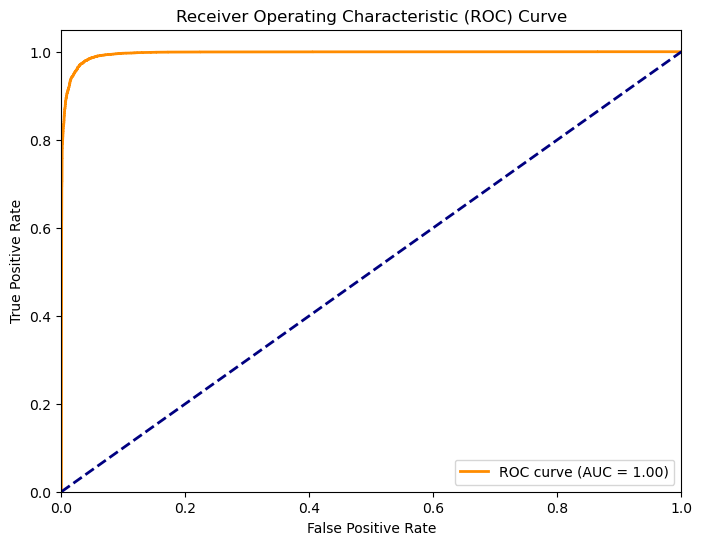

Accuracy: 0.97
Precision: 0.97
Recall: 0.98
F1 Score: 0.98
ROC AUC: 1.00


In [118]:
def binary_classification_evaluation(y_val, y_hat, threshold):
    # 이진 분류 평가 지표 계산
    y_pred = (y_hat >= threshold).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_hat)

    # ROC 곡선 그리기
    fpr, tpr, thresholds = roc_curve(y_val, y_hat)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # 결과 출력
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')

# binary_classification_evaluation 함수 호출
binary_classification_evaluation(y_val, y_hat, threshold=best_threshold)

Text(0, 0.5, 'Frequency')

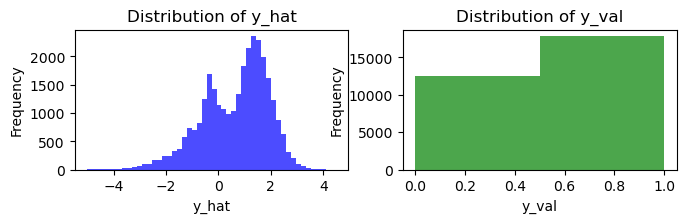

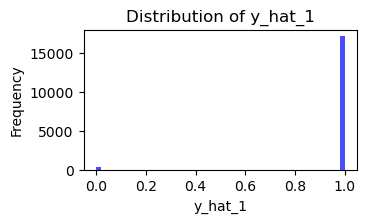

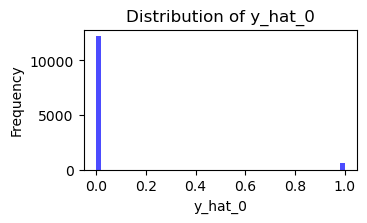

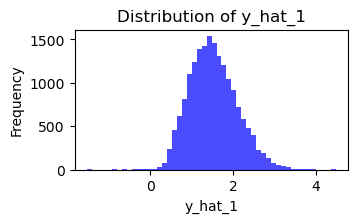

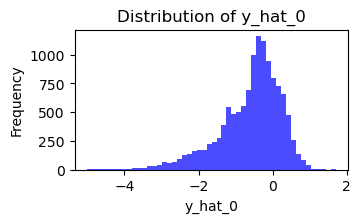

In [116]:
plt.figure(figsize=(12, 4))
plt.subplot(231)
plt.hist(y_hat, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of y_hat")
plt.xlabel("y_hat")
plt.ylabel("Frequency")

# y_val의 분포 시각화
plt.subplot(232)
plt.hist(y_val, bins=2, color='green', alpha=0.7)
plt.title("Distribution of y_val")
plt.xlabel("y_val")
plt.ylabel("Frequency")
    
threshold = 0.6

arr = y_hat.T[0]

selected_indices_1 = np.where(arr >= threshold)[0]
selected_indices_0 = np.where(arr < threshold)[0]

# y_val에서 해당 인덱스를 사용하여 값을 추출
y_val_1 = y_val[selected_indices_1]
y_val_0 = y_val[selected_indices_0]

plt.figure(figsize=(12, 4))
plt.subplot(233)
plt.hist(y_val_1, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of y_hat_1")
plt.xlabel("y_hat_1")
plt.ylabel("Frequency")

plt.figure(figsize=(12, 4))
plt.subplot(234)
plt.hist(y_val_0, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of y_hat_0")
plt.xlabel("y_hat_0")
plt.ylabel("Frequency")



selected_indices_3 = np.where(y_val == 1)[0]
selected_indices_4 = np.where(y_val == 0)[0]

# y_val에서 해당 인덱스를 사용하여 값을 추출
y_hat_1 = arr[selected_indices_3]
y_hat_0 = arr[selected_indices_4]

plt.figure(figsize=(12, 4))
plt.subplot(235)
plt.hist(y_hat_1, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of y_hat_1")
plt.xlabel("y_hat_1")
plt.ylabel("Frequency")

plt.figure(figsize=(12, 4))
plt.subplot(236)
plt.hist(y_hat_0, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of y_hat_0")
plt.xlabel("y_hat_0")
plt.ylabel("Frequency")

In [195]:
# input layer
input_shape_1 = (7, 7, 4)
input_shape_2 = (1, 14, 4)

input_layer_1 = Input(shape=input_shape_1)
input_layer_2 = Input(shape=input_shape_2)

# x1 layer
x1 = Conv2D(256, (2, 2))(input_layer_1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(512, (2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Flatten()(x1)

# x1 = Dense(128)(x1)
# x1 = BatchNormalization()(x1)
# x1 = Activation('relu')(x1)

# x1 = Dropout(0.5)(x1)

# x2 layer
x2 = Conv2D(16, (1,4))(input_layer_2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2D(32, (1, 4))(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Flatten()(x2)

# x2 = Dense(128)(x2)
# x2 = BatchNormalization()(x2)
# x2 = Activation('relu')(x2)
            
# x2 = Dropout(0.5)(x2)
            
#x3 layer
x3 = tf.concat([x1, x2], axis=1)
            
x3 = Dense(256)(x3)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
            
x3 = Dropout(0.5)(x3)

output_layer = Dense(2)(x3)

model = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)


# 초기 학습률 설정
initial_learning_rate = 0.001  # 초기 학습률을 설정

# 최소 학습률 설정 (학습률이 떨어질 때의 최소값)
min_learning_rate = 0.000000001

# 학습률 스케줄러 설정
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,  # 초기 학습률
    decay_steps=10000,       # 학습률을 감소시킬 스텝 수
    decay_rate=0.9,          # 학습률을 줄일 비율
    staircase=False
)

# Adam 옵티마이저를 생성하고 학습률 스케줄러 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 7, 7, 4)]    0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 6, 6, 256)    4352        ['input_50[0][0]']               
                                                                                                  
 batch_normalization_143 (Batch  (None, 6, 6, 256)   1024        ['conv2d_94[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 input_51 (InputLayer)          [(None, 1, 14, 4)]   0           []                        

In [243]:
# 데이터를 준비하고 분할
x_train_1 = input_data_array_t[0:89043]
x_train_2 = input_feature_array[0:89043]
y_train = input_label_array.T[0:2].T[0:89043]  # 타겟 데이터

x_train_1, x_val_1, x_train_2, x_val_2, y_train, y_val = train_test_split(x_train_1, x_train_2, y_train, test_size=0.2, random_state=my_seed)

# 모델 학습
batch_size = 8192
epochs = 30

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'siren_loc_model5.h5',
    monitor='val_loss',  # Check based on validation loss|
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the validation loss is minimized
)

# 입력 데이터 목록을 사용하여 모델 학습
model.fit([x_train_1, x_train_2], y_train, validation_data=([x_val_1, x_val_2], y_val), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 217.0404
Epoch 1: val_loss improved from inf to 184.49942, saving model to siren_loc_model5.h5
9/9 [==============================] - 1s 107ms/step - loss: 217.0404 - val_loss: 184.4994
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 217.9215
Epoch 2: val_loss did not improve from 184.49942
9/9 [==============================] - 1s 90ms/step - loss: 217.9215 - val_loss: 239.5587
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 219.8965
Epoch 3: val_loss did not improve from 184.49942
9/9 [==============================] - 1s 90ms/step - loss: 219.8965 - val_loss: 194.4896
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 217.1701
Epoch 4: val_loss did not improve from 184.49942
9/9 [==============================] - 1s 96ms/step - loss: 217.1701 - val_loss: 243.1109
Epoch 5/30
9/9 [==============================] - ETA: 0s - loss: 220.1985
Epoch 5: val_loss improved from

In [226]:
# 모델 불러오기
loaded_model = load_model('siren_loc_model0.h5')

In [228]:
y_hat = loaded_model.predict([x_val_1, x_val_2])

# 실제 y 값과 예측값 비교
rmse = np.sqrt(np.mean((y_hat-y_val)**2, axis=0, keepdims=True))
print()
print(f"x_rmse: {round(rmse[0][0],1)}, y_rmse: {round(rmse[0][1],1)}")
print()

val_loss = mean_squared_error(y_val, y_hat)
print(val_loss)

for i in range(10):
    print("Sample", i)
    print("Actual:", y_val[i])
    print("Predicted:", y_hat[i])

557/557 [==============================] - 1s 2ms/step

x_rmse: 10.5, y_rmse: 8.5

Sample 0
Actual: [  0. 115.]
Predicted: [ -3.2112386 103.93895  ]
Sample 1
Actual: [-110.   20.]
Predicted: [-121.4488    23.18261]
Sample 2
Actual: [-120.   50.]
Predicted: [-135.48607    55.633995]
Sample 3
Actual: [   0. -110.]
Predicted: [  3.4395437 -96.0918   ]
Sample 4
Actual: [-95.   5.]
Predicted: [-78.3481    -5.236438]
Sample 5
Actual: [-25.  55.]
Predicted: [-30.471611  57.449577]
Sample 6
Actual: [105.   5.]
Predicted: [97.759186 13.01246 ]
Sample 7
Actual: [-5. 15.]
Predicted: [-4.1130233 10.112118 ]
Sample 8
Actual: [120.  50.]
Predicted: [121.562805  46.749382]
Sample 9
Actual: [-25.  55.]
Predicted: [-24.586552  49.342648]


In [165]:
# input layer
input_shape_1 = (7, 7, 4)

input_layer_1 = Input(shape=input_shape_1)

# x1 layer
x1 = Conv2D(128, (2, 2))(input_layer_1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Conv2D(256, (2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((2, 2))(x1)

x1 = Flatten()(x1)

x1 = Dense(128)(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = Dropout(0.5)(x1)

output_layer = Dense(2)(x1)

model = Model(inputs=input_layer_1, outputs=output_layer)


# 초기 학습률 설정
initial_learning_rate = 0.001  # 초기 학습률을 설정

# 최소 학습률 설정 (학습률이 떨어질 때의 최소값)
min_learning_rate = 0.000000001

# 학습률 스케줄러 설정
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,  # 초기 학습률
    decay_steps=10000,       # 학습률을 감소시킬 스텝 수
    decay_rate=0.9,          # 학습률을 줄일 비율
    staircase=False
)

# Adam 옵티마이저를 생성하고 학습률 스케줄러 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 모델 요약 정보 출력
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 7, 7, 4)]         0         
                                                                 
 conv2d_63 (Conv2D)          (None, 6, 6, 128)         2176      
                                                                 
 batch_normalization_102 (Ba  (None, 6, 6, 128)        512       
 tchNormalization)                                               
                                                                 
 activation_102 (Activation)  (None, 6, 6, 128)        0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 3, 3, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 2, 2, 256)         131

In [166]:
# 데이터를 준비하고 분할
x_train_1 = input_data_array_t[0:89043]
y_train = input_label_array.T[0:2].T[0:89043]  # 타겟 데이터

x_train_1, x_val_1, y_train, y_val = train_test_split(x_train_1, y_train, test_size=0.2, random_state=my_seed)

# 모델 학습
batch_size = 128
epochs = 10

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'siren_loc_model.h5',
    monitor='val_loss',  # Check based on validation loss|
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the validation loss is minimized
)

# 입력 데이터 목록을 사용하여 모델 학습
model.fit(x_train_1, y_train, validation_data=(x_val_1, y_val), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint])

Epoch 1/10
550/557 [============================>.] - ETA: 0s - loss: 2196.7439
Epoch 1: val_loss improved from inf to 2360.30884, saving model to siren_loc_model.h5
557/557 [==============================] - 4s 5ms/step - loss: 2186.3787 - val_loss: 2360.3088
Epoch 2/10
556/557 [============================>.] - ETA: 0s - loss: 1084.4952
Epoch 2: val_loss improved from 2360.30884 to 1070.52051, saving model to siren_loc_model.h5
557/557 [==============================] - 3s 5ms/step - loss: 1084.6118 - val_loss: 1070.5205
Epoch 3/10
547/557 [============================>.] - ETA: 0s - loss: 835.7371
Epoch 3: val_loss improved from 1070.52051 to 869.53436, saving model to siren_loc_model.h5
557/557 [==============================] - 3s 5ms/step - loss: 835.6147 - val_loss: 869.5344
Epoch 4/10
554/557 [============================>.] - ETA: 0s - loss: 677.2723
Epoch 4: val_loss improved from 869.53436 to 851.57068, saving model to siren_loc_model.h5
557/557 [============================

# 학습

In [465]:
# 가상의 학습 데이터 생성
x_train = input_data_array_t
y_train = input_label_array

# 데이터 분할 (학습 및 검증 데이터)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=my_seed)

# 모델 학습
batch_size = 32
epochs = 14

model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
446/855 [==============>...............] - ETA: 8s - loss: 118.1612


KeyboardInterrupt



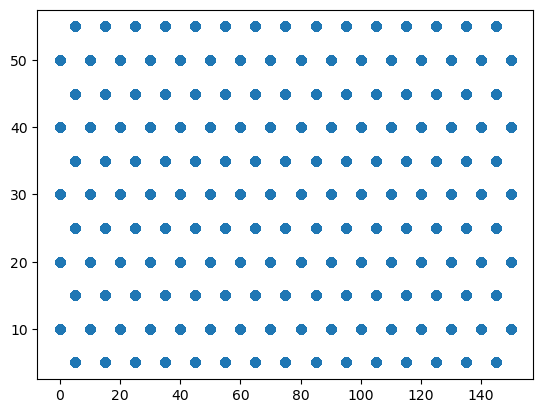

In [235]:
plt.scatter(y_train.T[0], y_train.T[1])

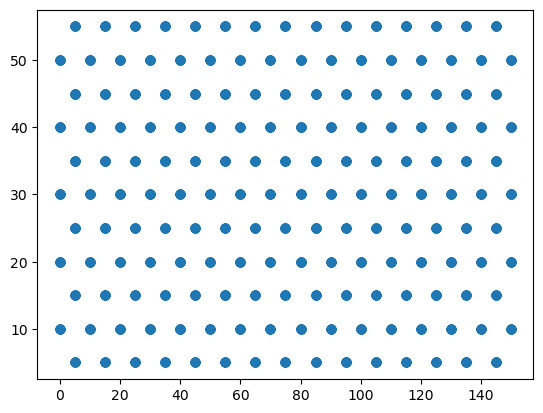

In [234]:
plt.scatter(y_val.T[0], y_val.T[1])

## 다중입력 (model v8 이후)

In [31]:
# 데이터를 준비하고 분할
x_train_1 = input_data_array_t
x_train_2 = input_feature_array
y_train = input_label_array  # 타겟 데이터

x_train_1, x_val_1, x_train_2, x_val_2, y_train, y_val = train_test_split(x_train_1, x_train_2, y_train, test_size=0.2, random_state=my_seed)

# 모델 학습
batch_size = 128
epochs = 10

# 입력 데이터 목록을 사용하여 모델 학습
model.fit([x_train_1, x_train_2], y_train, validation_data=([x_val_1, x_val_2], y_val), batch_size=batch_size, epochs=epochs)

Epoch 1/10
949/949 [==============================] - 12s 11ms/step - loss: 1549.9991 - val_loss: 1141.1074
Epoch 2/10
949/949 [==============================] - 11s 11ms/step - loss: 895.0121 - val_loss: 979.7974
Epoch 3/10
949/949 [==============================] - 11s 11ms/step - loss: 727.1505 - val_loss: 676.7417
Epoch 4/10
949/949 [==============================] - 11s 12ms/step - loss: 610.9987 - val_loss: 827.9844
Epoch 5/10
949/949 [==============================] - 11s 12ms/step - loss: 532.0524 - val_loss: 583.9212
Epoch 6/10
949/949 [==============================] - 10s 11ms/step - loss: 487.8702 - val_loss: 442.1367
Epoch 7/10
949/949 [==============================] - 10s 11ms/step - loss: 454.9087 - val_loss: 651.0227
Epoch 8/10
949/949 [==============================] - 11s 11ms/step - loss: 424.8930 - val_loss: 514.1674
Epoch 9/10
949/949 [==============================] - 10s 11ms/step - loss: 393.0928 - val_loss: 356.1907
Epoch 10/10
949/949 [=======================

In [119]:
model_path = "siren_clf_model.h5"

# 모델을 HDF5 형식으로 저장
model.save(model_path)

# 평가

In [158]:
y_hat = model.predict([x_val_1, x_val_2])

# 실제 y 값과 예측값 비교
rmse = np.sqrt(np.mean((y_hat-y_val)**2, axis=0, keepdims=True))
print()
print(f"x_rmse: {round(rmse[0][0],1)}, y_rmse: {round(rmse[0][1],1)}")
print()

for i in range(10):
    print("Sample", i)
    print("Actual:", y_val[i])
    print("Predicted:", y_hat[i])

557/557 [==============================] - 1s 2ms/step

x_rmse: 27.6, y_rmse: 25.6

Sample 0
Actual: [  0. 115.]
Predicted: [ 5.530244 94.471924]
Sample 1
Actual: [-110.   20.]
Predicted: [-116.767876   31.392862]
Sample 2
Actual: [-120.   50.]
Predicted: [-158.73819    26.001818]
Sample 3
Actual: [   0. -110.]
Predicted: [  9.909099 -34.837776]
Sample 4
Actual: [-95.   5.]
Predicted: [-71.49003   45.100582]
Sample 5
Actual: [-25.  55.]
Predicted: [ 3.2889583 24.088165 ]
Sample 6
Actual: [105.   5.]
Predicted: [67.70896    7.5266376]
Sample 7
Actual: [-5. 15.]
Predicted: [-2.663324  7.703454]
Sample 8
Actual: [120.  50.]
Predicted: [120.80582   47.300293]
Sample 9
Actual: [-25.  55.]
Predicted: [12.054098 26.980715]


In [23]:
y_hat.T[2]

array([0.50695467, 0.6666105 , 0.74965   , ..., 0.91760564, 0.74153346,
       0.32355195], dtype=float32)